# Imports y configuraciones

In [1]:
# Módulos estándar de Python
import os
import shutil
from collections import Counter

# Librerías científicas y de visualización
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Machine Learning y preprocesamiento
from imblearn.over_sampling import SMOTE
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.svm import SVC

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, ConvNeXtTiny
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

# Funciones auxiliares

In [2]:
# Funciones auxiliares

def plot_distribution(y, title):
    """
    Muestra la distribución de clases en un gráfico de barras.

    Parámetros:
    - y: etiquetas de las clases
    - title: título del gráfico
    """
    counter = Counter(y)
    print(f"Distribución de clases ({title}):", counter)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de muestras")
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, feature_name, label_map):
    """
    Genera y muestra una matriz de confusión con etiquetas legibles.

    Parámetros:
    - y_true: etiquetas reales
    - y_pred: etiquetas predichas
    - feature_name: nombre del extractor de características usado
    - label_map: diccionario de etiquetas de las clases
    - title_suffix: texto adicional para el título (ej. "antes de SMOTE" o "después de SMOTE")
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {feature_name}")
    plt.show()


def train_model(X, y):
    """
    Entrena un modelo SVM con los datos proporcionados.

    Parámetros:
    - X: características de entrada
    - y: etiquetas

    Retorna:
    - X_train, X_test, y_train, y_test, y_pred
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    svm = SVC(kernel='linear', class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return X_train, X_test, y_train, y_test, y_pred


# Ref. https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def evaluate_model(y_test, y_pred, feature_name, X_train, y_train):
    """
    Evalúa el modelo entrenado y muestra el reporte de clasificación junto con la curva de aprendizaje.

    Parámetros:
    - y_test: etiquetas reales
    - y_pred: etiquetas predichas
    - feature_name: nombre del extractor de características usado
    - X_train: datos de entrenamiento
    - y_train: etiquetas de entrenamiento
    """
    print(f"Resultados para {feature_name}:")
    print(classification_report(y_test, y_pred))

    train_sizes, train_scores, test_scores = learning_curve(
        # Analiza cómo varía la precisión al entrenar con diferentes cantidades de datos
        SVC(kernel='linear', class_weight='balanced'),
        X_train, y_train,
        cv=5,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 3),  # Reduce aún más el número de pruebas → [0.1, 0.55, 1.0]
        n_jobs=-1  # Usa todos los núcleos disponibles de la CPU para paralelizar el cálculo
    )

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Entrenamiento")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Validación")
    plt.xlabel("Cantidad de Datos")
    plt.ylabel("Precisión")
    plt.legend()
    plt.title(f"Curva de Aprendizaje - {feature_name}")
    plt.show()


# Crear el modelo ViT usando Keras
def create_vit_model():
    """Modelo Vision Transformer simplificado en TensorFlow/Keras"""
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Convertir imagen en parches y proyectar
    x = layers.Conv2D(64, (PATCH_SIZE, PATCH_SIZE), strides=(PATCH_SIZE, PATCH_SIZE), padding="valid")(inputs)
    x = layers.Reshape((-1, x.shape[-1]))(x)

    # Aplicar Multi-Head Attention
    x = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = layers.LayerNormalization()(x)

    # Aplanar y añadir capas densas
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Carga del dataset

In [3]:
# Ruta del dataset
dataset_final_path = "data/EuroSAT/"
train_csv_path = "data/EuroSAT/train.csv"

# Descarga el dataset si no existe en la carpeta data
if not os.path.exists(dataset_final_path):
    print("Descargando el dataset...")
    download_path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

    # Buscar la carpeta correcta dentro de la descarga
    possible_folders = ["EuroSAT", "EuroSATallBands"]
    original_path = None

    for folder in possible_folders:
        candidate_path = os.path.join(download_path, folder)
        if os.path.exists(candidate_path):
            original_path = candidate_path
            break

    # Si no se encontró la carpeta esperada, lanzar un error
    if original_path is None:
        print(f"Error: No se encontró ninguna de las carpetas {possible_folders} dentro de {download_path}.")
        exit()

    # Asegurar que la carpeta de destino exista
    os.makedirs(os.path.dirname(dataset_final_path), exist_ok=True)

    # Mover el dataset a la carpeta `data/EuroSAT/`
    shutil.move(original_path, dataset_final_path)
    print(f"Dataset movido a: {dataset_final_path}")
else:
    print("El dataset ya está descargado. No es necesario volver a descargarlo")

El dataset ya está descargado. No es necesario volver a descargarlo


In [4]:
# Cargar el archivo CSV con la lista de imágenes a usar
df = pd.read_csv(train_csv_path)

In [5]:
# Reduce el dataset seleccionando aleatoriamente un 50% de las filas
reduction_factor = 0.5  # Proporción del dataset a conservar
df = df.sample(frac=reduction_factor, random_state=42).reset_index(drop=True)
print(f"Dataset reducido al {reduction_factor * 100}% del tamaño original")

Dataset reducido al 50.0% del tamaño original


In [6]:
# Ver las primeras filas del CSV
display(df.head())

,Unnamed: 0,Filename,Label,ClassName
0,6524,Residential/Residential_2442.jpg,7,Residential
1,4480,HerbaceousVegetation/HerbaceousVegetation_2683...,2,HerbaceousVegetation
2,10328,River/River_798.jpg,8,River
3,10844,River/River_87.jpg,8,River
4,17691,PermanentCrop/PermanentCrop_1474.jpg,6,PermanentCrop


In [7]:
# Extraer nombres de archivo y etiquetas
image_filenames = df["Filename"].tolist()
image_labels = df["Label"].tolist()

# Crear un diccionario para mapear etiquetas numéricas a nombres de clase
label_map = dict(zip(df["ClassName"].unique(), df["Label"].unique()))

print("Etiquetas:", label_map)

Etiquetas: {'Residential': 7, 'HerbaceousVegetation': 2, 'River': 8, 'PermanentCrop': 6, 'Highway': 3, 'Industrial': 4, 'AnnualCrop': 0, 'SeaLake': 9, 'Forest': 1, 'Pasture': 5}


# Extracción de características, entrenamiento, evaluación y visualización de resultados de los modelos tradicionales

In [72]:
# Extracción de características Haralick, HOG y LBP de las imágenes

# Ref. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix
# Ref. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycoprops
# Ref. https://medium.com/top-python-libraries/12-examples-of-image-texture-analysis-in-python-6cf7c179ada7
# Ref. https://medium.com/@girishajmera/feature-extraction-of-images-using-glcm-gray-level-cooccurrence-matrix-e4bda8729498
# Ref. https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8


# Parámetros para calcular la matriz de co-ocurrencia de niveles de gris (GLCM)
distances = [1]  # Distancia de 1 píxel entre los valores a comparar
angles = [0]  # Ángulo de 0 grados (horizontal) para evaluar la textura

X_haralick, X_hog, X_lbp, X_combined, y = [], [], [], [], []

# Recorrer las imágenes listadas en train.csv
for img_filename, label in zip(image_filenames, image_labels):
    img_path = os.path.join(dataset_final_path, img_filename)

    # Cargar la imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Si la imagen no se puede leer, se ignora
    if img is None:
        continue

    # Calcula la matriz de co-ocurrencia de niveles de gris (GLCM)
    glcm = graycomatrix(img, distances, angles, symmetric=True, normed=True)

    # Extracción de características de Haralick
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    haralick_features = [contrast, dissimilarity, homogeneity, energy, correlation, asm]

    # Extracción de características usando el histograma de gradientes orientados (HOG)
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

    # Extracción de características usando Local Binary Patterns (LBP)
    lbp_features = local_binary_pattern(img, P=8, R=1).flatten()

    # Almacenar las características en listas separadas
    X_haralick.append(haralick_features)
    X_hog.append(list(hog_features))
    X_lbp.append(list(lbp_features))
    X_combined.append(haralick_features + list(hog_features) + list(lbp_features))
    y.append(label)

print("Extracción de características completada")

Extracción de características completada


In [73]:
# Convierte los datos en arrays
X_haralick = np.array(X_haralick)
X_hog = np.array(X_hog)
X_lbp = np.array(X_lbp)
X_combined = np.array(X_combined)
y = np.array(y)

Distribución de clases (Distribución de Clases Antes de SMOTE): Counter({0: 1076, 7: 1057, 2: 1046, 1: 1046, 9: 1021, 3: 924, 8: 888, 6: 860, 4: 854, 5: 678})


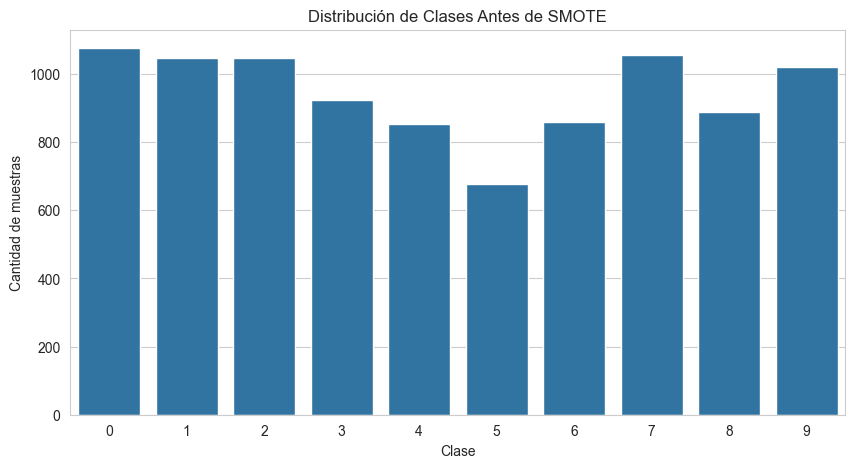

In [74]:
# Visualizar la distribución de clases antes de aplicar SMOTE
plot_distribution(y, "Distribución de Clases Antes de SMOTE")

In [75]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_haralick_resampled, y_resampled = smote.fit_resample(X_haralick, y)
X_hog_resampled, _ = smote.fit_resample(X_hog, y)
X_lbp_resampled, _ = smote.fit_resample(X_lbp, y)
X_combined_resampled, _ = smote.fit_resample(X_combined, y)

Distribución de clases (Distribución de Clases Después de SMOTE): Counter({7: 1076, 2: 1076, 8: 1076, 6: 1076, 3: 1076, 4: 1076, 0: 1076, 9: 1076, 1: 1076, 5: 1076})


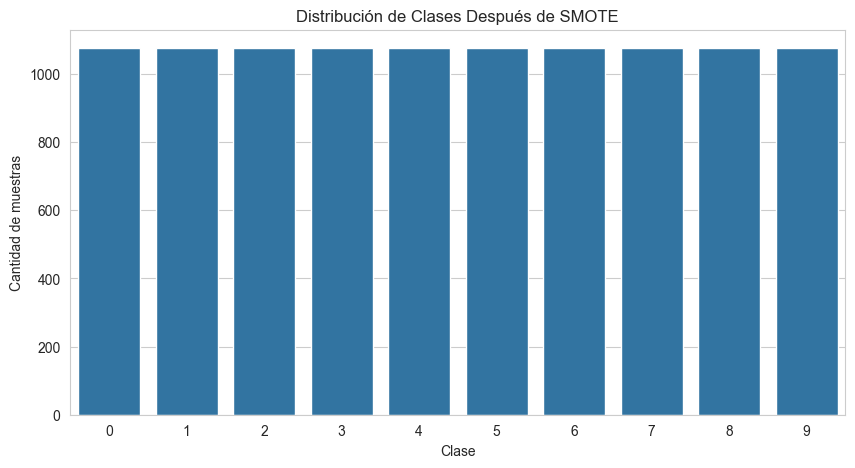

In [76]:
# Visualizar la distribución de clases después de aplicar SMOTE
plot_distribution(y_resampled, "Distribución de Clases Después de SMOTE")

Resultados para Haralick (GLCM):
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       197
           1       0.86      0.89      0.88       227
           2       0.45      0.47      0.46       227
           3       0.35      0.17      0.23       216
           4       0.79      0.88      0.83       207
           5       0.59      0.72      0.65       222
           6       0.40      0.53      0.46       209
           7       0.83      0.86      0.85       222
           8       0.69      0.37      0.48       208
           9       0.94      0.95      0.95       217

    accuracy                           0.66      2152
   macro avg       0.65      0.65      0.64      2152
weighted avg       0.65      0.66      0.64      2152



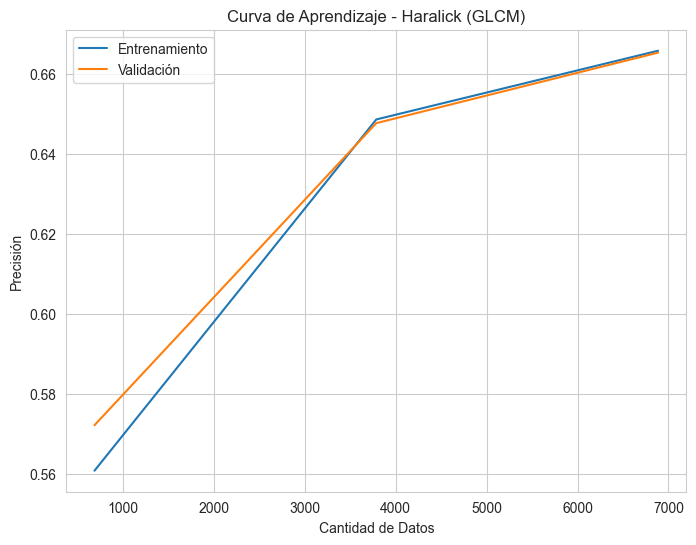

In [77]:
# Entrenamiento y evaluación con Haralick (GLCM)
X_train_haralick, X_test_haralick, y_train_haralick, y_test_haralick, y_pred_haralick = train_model(
    X_haralick_resampled, y_resampled)

evaluate_model(y_test_haralick, y_pred_haralick, "Haralick (GLCM)", X_train_haralick, y_train_haralick)

Resultados para HOG:
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       197
           1       0.86      0.87      0.87       227
           2       0.46      0.55      0.50       227
           3       0.59      0.62      0.61       216
           4       0.68      0.69      0.68       207
           5       0.75      0.68      0.72       222
           6       0.48      0.41      0.44       209
           7       0.80      0.72      0.76       222
           8       0.60      0.58      0.59       208
           9       0.96      0.97      0.97       217

    accuracy                           0.67      2152
   macro avg       0.67      0.67      0.67      2152
weighted avg       0.68      0.67      0.67      2152



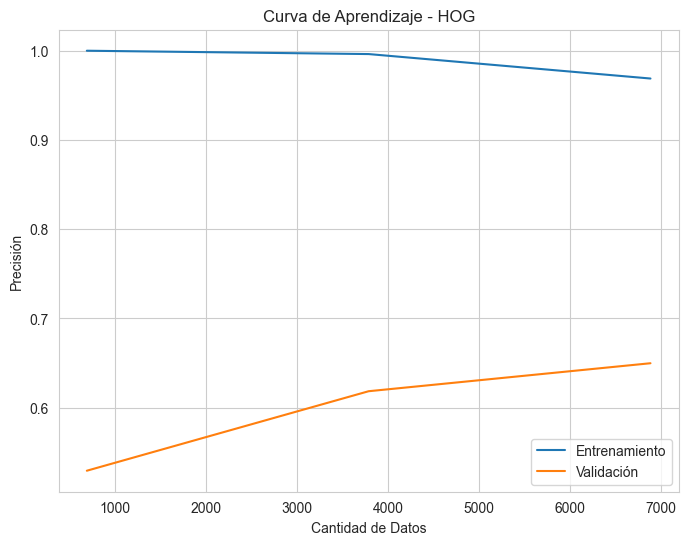

In [78]:
# Entrenamiento y evaluación con HOG
X_train_hog, X_test_hog, y_train_hog, y_test_hog, y_pred_hog = train_model(
    X_hog_resampled, y_resampled)

evaluate_model(y_test_hog, y_pred_hog, "HOG", X_train_hog, y_train_hog)

Resultados para LBP:
              precision    recall  f1-score   support

           0       0.13      0.18      0.15       197
           1       0.35      0.30      0.32       227
           2       0.21      0.22      0.21       227
           3       0.32      0.34      0.33       216
           4       0.40      0.47      0.43       207
           5       0.53      0.56      0.55       222
           6       0.43      0.42      0.42       209
           7       0.33      0.25      0.28       222
           8       0.48      0.39      0.43       208
           9       0.90      0.87      0.88       217

    accuracy                           0.40      2152
   macro avg       0.41      0.40      0.40      2152
weighted avg       0.41      0.40      0.40      2152



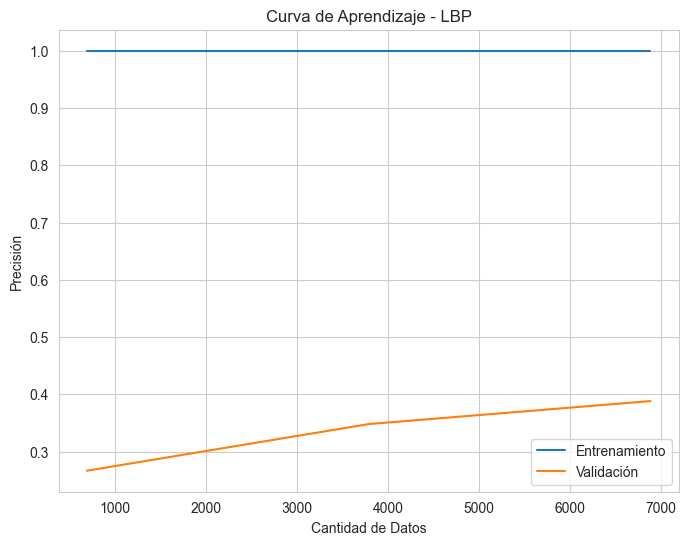

In [79]:
# Entrenamiento y evaluación con LBP
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp, y_pred_lbp = train_model(
    X_lbp_resampled, y_resampled)

evaluate_model(y_test_lbp, y_pred_lbp, "LBP", X_train_lbp, y_train_lbp)

Resultados para Haralick + HOG + LBP:
              precision    recall  f1-score   support

           0       0.16      0.23      0.19       197
           1       0.35      0.30      0.32       227
           2       0.23      0.25      0.24       227
           3       0.34      0.36      0.35       216
           4       0.76      0.67      0.71       207
           5       0.54      0.57      0.55       222
           6       0.42      0.44      0.43       209
           7       0.39      0.28      0.32       222
           8       0.47      0.42      0.45       208
           9       0.90      0.87      0.88       217

    accuracy                           0.44      2152
   macro avg       0.45      0.44      0.44      2152
weighted avg       0.45      0.44      0.44      2152



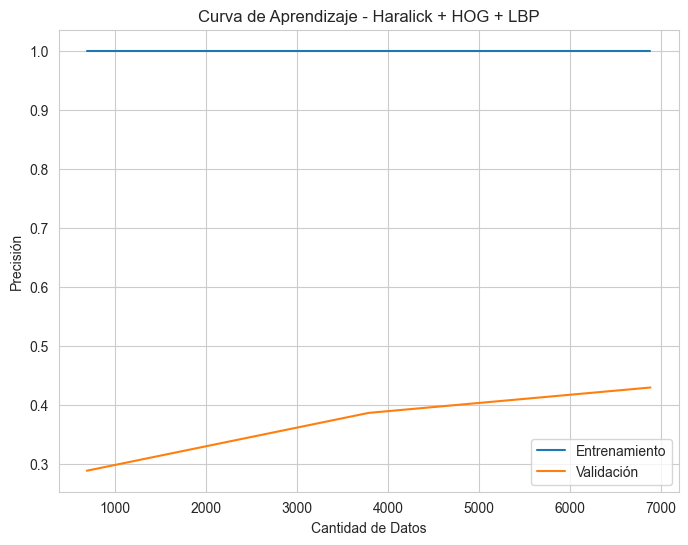

In [80]:
# Entrenamiento y evaluación combinando todos los extractores de características
X_train_combined, X_test_combined, y_train_combined, y_test_combined, y_pred_combined = train_model(
    X_combined_resampled, y_resampled)

evaluate_model(y_test_combined, y_pred_combined, "Haralick + HOG + LBP", X_train_combined, y_train_combined)

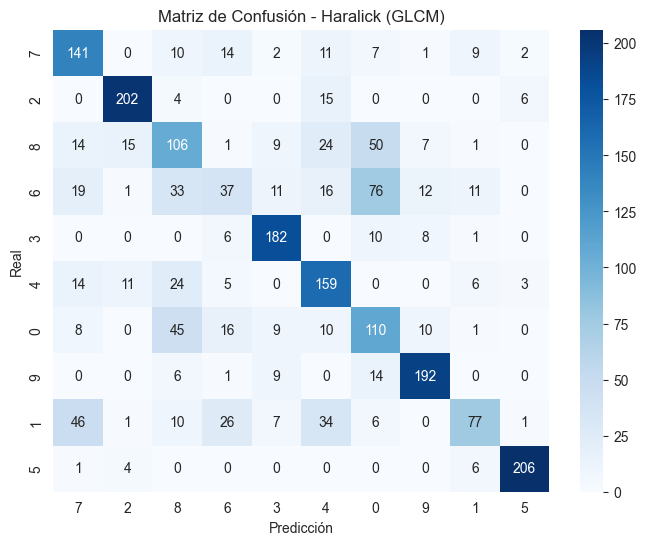

In [81]:
# Mostrar la matriz de confusión para Haralick (GLCM)
plot_confusion_matrix(y_test_haralick, y_pred_haralick, "Haralick (GLCM)", label_map)

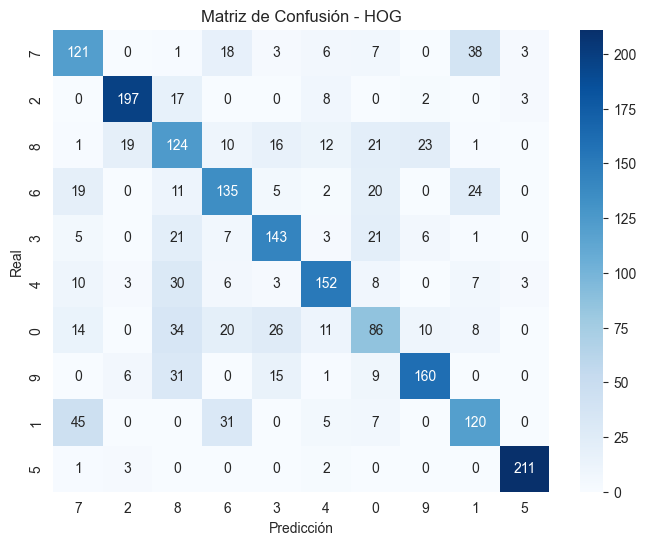

In [82]:
# Mostrar la matriz de confusión para HOG
plot_confusion_matrix(y_test_hog, y_pred_hog, "HOG", label_map)

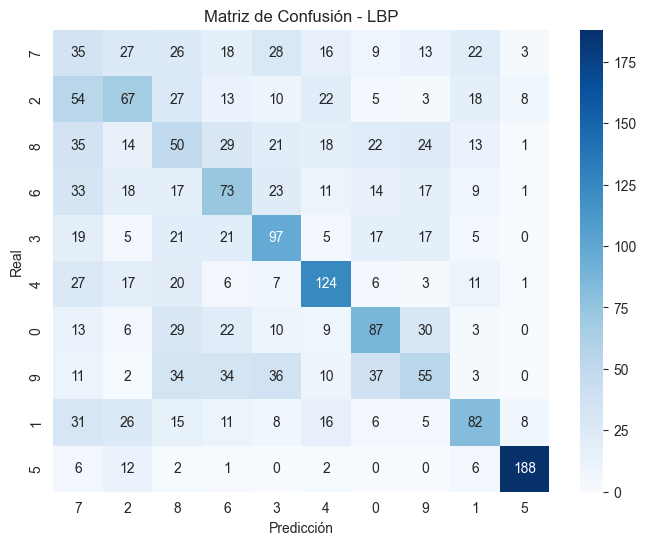

In [83]:
# Mostrar la matriz de confusión para LBP
plot_confusion_matrix(y_test_lbp, y_pred_lbp, "LBP", label_map)

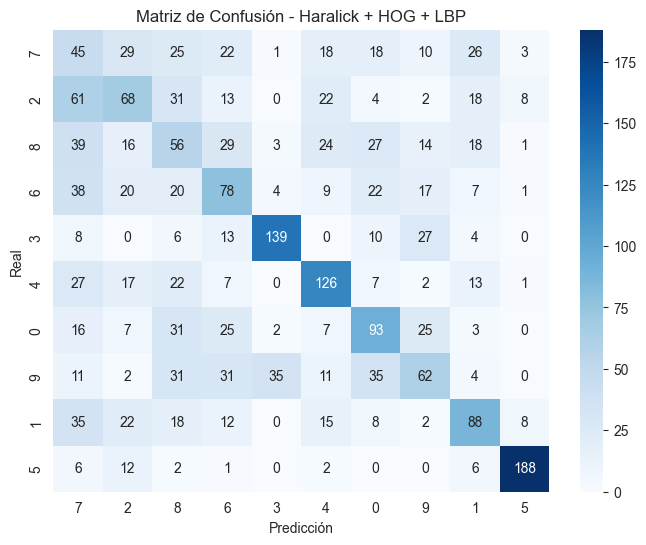

In [84]:
# Mostrar la matriz de confusión para la combinación de Haralick + HOG + LBP
plot_confusion_matrix(y_test_combined, y_pred_combined, "Haralick + HOG + LBP", label_map)

# Redes neuronales

In [85]:
# Ref. https://medium.com/@hassaanidrees7/vision-transformer-vs-cnn-a-comparison-of-two-image-processing-giants-d6c85296f34f
# Ref. https://www.reddit.com/r/computervision/comments/1cu3pnw/cnn_vs_vision_transformer_a_practitioners_guide/?tl=es-es
# Ref. https://docs.kanaries.net/es/topics/ChatGPT/convnext
# Ref. https://www.toolify.ai/es/ai-news-es/descubre-el-fascinante-mundo-del-swin-transformer-552304
# Ref. https://www.geeksforgeeks.org/vision-transformers-vs-convolutional-neural-networks-cnns/
# Ref. https://flypix.ai/blog/image-recognition-models-cnns/
# Ref. https://stackoverflow.com/questions/79128531/problems-running-convnext-models-from-tensorflow-keras-applications-on-my-macboo

## Red Neuronal Convolucional (CNN) desde cero

In [8]:
# Tamaño de las imágenes para la CNN
IMG_SIZE = 64
NUM_CLASSES = len(label_map)

# Cargar imágenes y etiquetas en formato adecuado
X = []
y = []

for img_filename, label in zip(image_filenames, image_labels):
    img_path = os.path.join(dataset_final_path, img_filename)
    img = cv2.imread(img_path)  # Mantener las imágenes en color (RGB)
    if img is None:
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Redimensionar
    img = img / 255.0  # Normalizar entre 0 y 1
    X.append(img)
    y.append(label)

# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

# One-hot encoding de las etiquetas
y = to_categorical(y, num_classes=NUM_CLASSES)

print("Carga de imágenes completada")

Carga de imágenes completada


In [87]:
# Definir la arquitectura de la CNN
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Definir la forma de entrada aquí

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización para evitar overfitting
    Dense(NUM_CLASSES, activation='softmax')  # Clasificación multiclase
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar la CNN
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.2212 - loss: 2.0372 - val_accuracy: 0.4651 - val_loss: 1.4199
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3661 - loss: 1.5976 - val_accuracy: 0.4878 - val_loss: 1.2647
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4712 - loss: 1.3833 - val_accuracy: 0.6344 - val_loss: 1.0319
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5593 - loss: 1.1960 - val_accuracy: 0.6534 - val_loss: 0.9439
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6093 - loss: 1.1129 - val_accuracy: 0.6889 - val_loss: 0.8765
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6390 - loss: 1.0208 - val_accuracy: 0.6101 - val_loss: 1.0902
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6524 - loss: 1.0050 - val_accuracy: 0.7233 - val_loss: 0.7599
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6871 - loss: 0.9109 - val_accu

In [89]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7810 - loss: 1.9357
Precisión en test: 0.7894


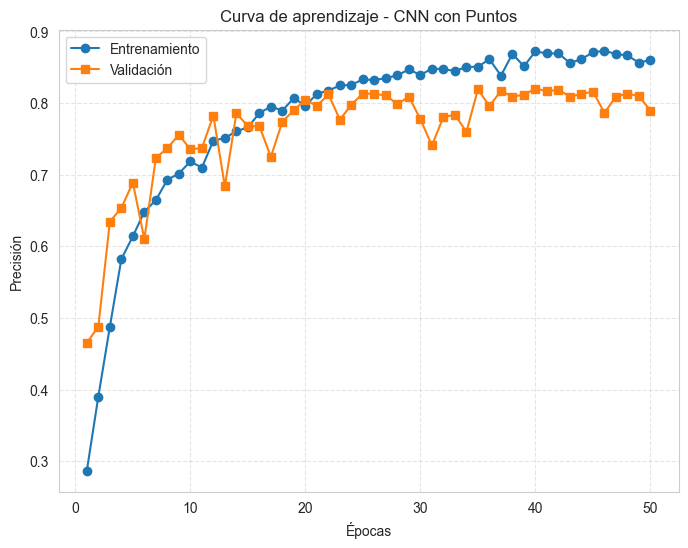

In [90]:
# Obtener los valores de accuracy
epochs = range(1, len(history.history['accuracy']) + 1)  # Números de época

# Crear la gráfica con puntos y líneas
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['accuracy'], marker='o', linestyle='-', label='Entrenamiento')  # Línea + puntos
plt.plot(epochs, history.history['val_accuracy'], marker='s', linestyle='-',
         label='Validación')  # Cuadrados para validación

# Agregar etiquetas y leyenda
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Curva de aprendizaje - CNN con Puntos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Cuadrícula más suave

# Mostrar la gráfica
plt.show()

## Vision Transformer (ViT)

In [91]:
# Parámetros del modelo
IMG_SIZE = 64  # Tamaño de imagen de entrada
PATCH_SIZE = 8  # Tamaño de los parches
NUM_CLASSES = 10  # Número de clases (ajustar según el dataset)

# Crear y compilar el modelo
vit_model = create_vit_model()
vit_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Mostrar resumen del modelo
vit_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 64)  │     12,352 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64)    │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │    132,672 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 4096)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    524,416 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │      1,290 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 670,858 (2.56 MB)

 Trainable params: 670,858 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Entrenar el modelo ViT
history_vit = vit_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

print("✅ Entrenamiento de ViT completado")

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.1417 - loss: 4.5708 - val_accuracy: 0.2180 - val_loss: 2.4020
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.2325 - loss: 2.4653 - val_accuracy: 0.3968 - val_loss: 1.8978
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.2782 - loss: 2.3541 - val_accuracy: 0.2868 - val_loss: 1.9473
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.3109 - loss: 1.9547 - val_accuracy: 0.4058 - val_loss: 1.9844
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.3678 - loss: 1.9965 - val_accuracy: 0.3799 - val_loss: 2.3303
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.2600 - loss: 2.9015 - val_accuracy: 0.3153 - val_loss: 2.1497
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.3436 - loss: 1.8797 - val_accuracy: 0.2026 - val_loss: 2.6816
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.2864 - loss: 2.3189 - 

In [93]:
# Evaluar el modelo ViT en test
test_loss_vit, test_acc_vit = vit_model.evaluate(X_test, y_test)
print(f"✅ Precisión en test - ViT: {test_acc_vit:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3726 - loss: 53.3040
✅ Precisión en test - ViT: 0.3757


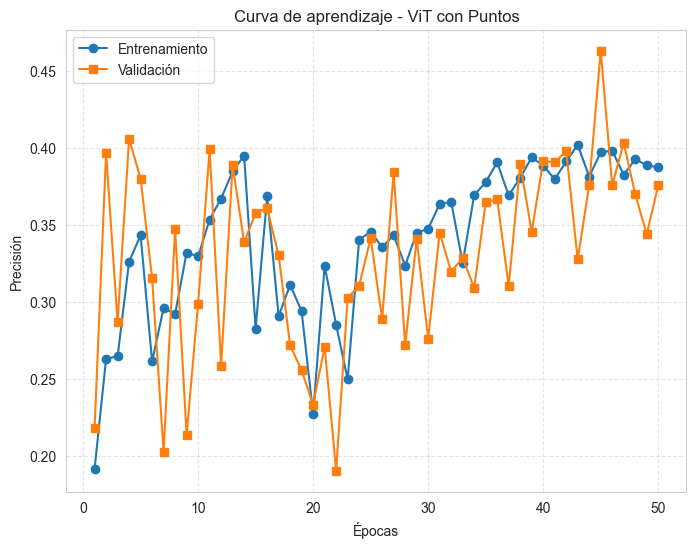

In [94]:
# Obtener los valores de accuracy para ViT
epochs = range(1, len(history_vit.history['accuracy']) + 1)  # Números de época

# Crear la gráfica con puntos y líneas
plt.figure(figsize=(8, 6))
plt.plot(epochs, history_vit.history['accuracy'], marker='o', linestyle='-', label='Entrenamiento')  # Línea + puntos
plt.plot(epochs, history_vit.history['val_accuracy'], marker='s', linestyle='-',
         label='Validación')  # Cuadrados para validación

# Agregar etiquetas y leyenda
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Curva de aprendizaje - ViT con Puntos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Cuadrícula más suave

# Mostrar la gráfica
plt.show()

## ResNet50 (CNN preentrenada)


In [95]:
# Definir la arquitectura de ResNet50 con pesos preentrenados en ImageNet
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelar las capas del modelo base para reutilizar sus características
base_model.trainable = False

# Agregar capas personalizadas para ajustar el modelo a nuestro dataset
x = Flatten()(base_model.output)  # Aplanar salida de ResNet
x = Dense(128, activation="relu")(x)  # Capa densa intermedia
x = Dense(NUM_CLASSES, activation="softmax")(x)  # Capa de salida para clasificación

# Definir el modelo final
resnet_model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Mostrar la arquitectura
resnet_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,706 (93.99 MB)

 Trainable params: 1,049,994 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [96]:
history_resnet = resnet_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.1960 - loss: 2.2511 - val_accuracy: 0.3116 - val_loss: 1.8485
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.3359 - loss: 1.8032 - val_accuracy: 0.3921 - val_loss: 1.6551
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4028 - loss: 1.6321 - val_accuracy: 0.4021 - val_loss: 1.5358
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4119 - loss: 1.5473 - val_accuracy: 0.4804 - val_loss: 1.4839
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4392 - loss: 1.4880 - val_accuracy: 0.4032 - val_loss: 1.5535
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4510 - loss: 1.4689 - val_accuracy: 0.5132 - val_loss: 1.4306
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4609 - loss: 1.4252 - val_accuracy: 0.4582 - val_loss: 1.4017
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4614 - loss: 1.4152 - val_acc

In [97]:
test_loss, test_acc = resnet_model.evaluate(X_test, y_test)
print(f"Precisión en test (ResNet50): {test_acc:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5903 - loss: 1.1581
Precisión en test (ResNet50): 0.5841


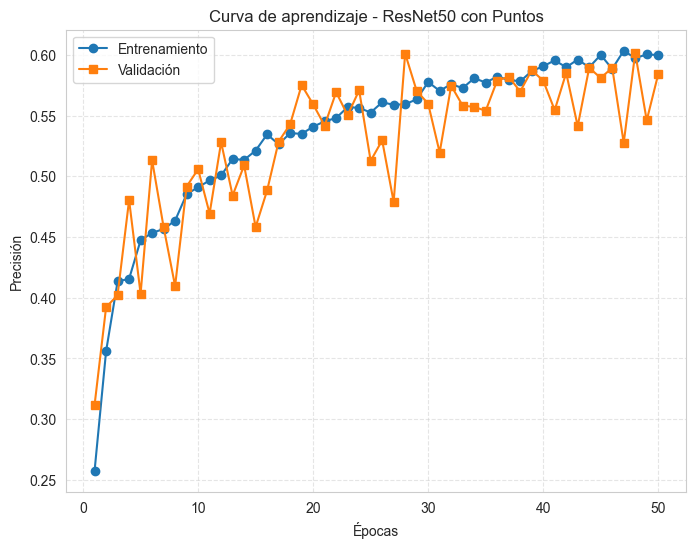

In [98]:
# Obtener los valores de accuracy
epochs = range(1, len(history_resnet.history['accuracy']) + 1)

# Crear la gráfica con puntos y líneas
plt.figure(figsize=(8, 6))
plt.plot(epochs, history_resnet.history['accuracy'], marker='o', linestyle='-', label='Entrenamiento')
plt.plot(epochs, history_resnet.history['val_accuracy'], marker='s', linestyle='-', label='Validación')

# Agregar etiquetas y leyenda
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Curva de aprendizaje - ResNet50 con Puntos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar la gráfica
plt.show()

## ConvNeXt (Híbrido: CNN + Transformer)

In [52]:
# Redimensionar imágenes a 224x224 (requisito de ConvNeXtBase)
X_train_resized = tf.image.resize(X_train, (224, 224))
X_test_resized = tf.image.resize(X_test, (224, 224))

# Definir la arquitectura de ConvNeXt con pesos preentrenados en ImageNet
with tf.device('/CPU:0'):  # Asegurar que se construye en la CPU
    base_model = tf.keras.applications.ConvNeXtBase(
        weights="imagenet", include_top=False, input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Congelar capas preentrenadas

    # Construir el modelo con capas adicionales
    x = Flatten()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation="softmax")(x)

    convnext_model = Model(inputs=base_model.input, outputs=x)
    convnext_model.summary()

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_70      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 224, 224,  │          0 │ input_layer_70[0… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 56, 56,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_414 (Add)       │ (None, 56, 56,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │      6,400 │ add_414[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        128 │ convnext_base_st

 Total params: 93,990,410 (358.54 MB)

 Trainable params: 6,423,946 (24.51 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [57]:
# Optimizar el preprocesamiento de los datos
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train_resized, y_train))
    .shuffle(len(X_train_resized))
    .batch(64)  # Aumentamos batch size
    .prefetch(AUTOTUNE)  # Precarga en memoria
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test_resized, y_test))
    .batch(64)
    .prefetch(AUTOTUNE)
)

# Compilar el modelo con un optimizador más rápido en CPU
convnext_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenar en CPU con dataset optimizado
with tf.device('/CPU:0'):
    history_convnext = convnext_model.fit(
        train_dataset, epochs=5, validation_data=test_dataset
    )

print("✅ Entrenamiento de ConvNeXt optimizado completado en CPU")

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 4436s 37s/step - accuracy: 0.1724 - loss: 2.1932 - val_accuracy: 0.1825 - val_loss: 2.1295
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 4374s 37s/step - accuracy: 0.1314 - loss: 2.2581 - val_accuracy: 0.1085 - val_loss: 2.2989
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 4336s 37s/step - accuracy: 0.1121 - loss: 2.2984 - val_accuracy: 0.1085 - val_loss: 2.2958
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 4300s 36s/step - accuracy: 0.1200 - loss: 2.2917 - val_accuracy: 0.1085 - val_loss: 2.2955
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 4318s 36s/step - accuracy: 0.1198 - loss: 2.2914 - val_accuracy: 0.1085 - val_loss: 2.2957
✅ Entrenamiento de ConvNeXt optimizado completado en CPU


In [60]:
# Evaluar el modelo ConvNeXt en la CPU para evitar problemas de acceso a dispositivos
with tf.device('/CPU:0'):
    test_loss_convnext, test_acc_convnext = convnext_model.evaluate(X_test_resized, y_test)

print(f"✅ Precisión en test - ConvNeXt: {test_acc_convnext:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 921s 15s/step - accuracy: 0.1054 - loss: 2.2959
✅ Precisión en test - ConvNeXt: 0.1085


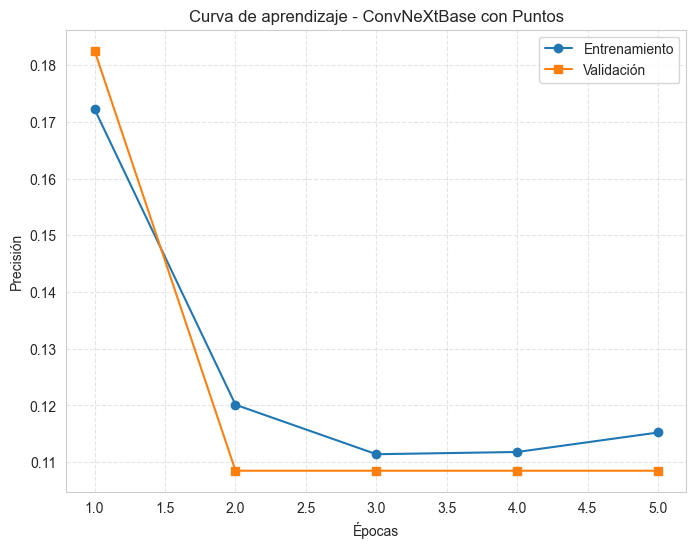

In [61]:
# Obtener los valores de accuracy para ConvNeXt
epochs = range(1, len(history_convnext.history['accuracy']) + 1)

# Crear la gráfica con puntos y líneas
plt.figure(figsize=(8, 6))
plt.plot(epochs, history_convnext.history['accuracy'], marker='o', linestyle='-', label='Entrenamiento')
plt.plot(epochs, history_convnext.history['val_accuracy'], marker='s', linestyle='-', label='Validación')

# Agregar etiquetas y leyenda
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Curva de aprendizaje - ConvNeXtBase con Puntos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar la gráfica
plt.show()